In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.append('../scripts')
from paths import SIMULATED_PATH, SIMULATED_DATA_ROOT
import matplotlib.pyplot as plt

### Mnist dataset

In [2]:
mnist_data = tf.keras.datasets.mnist.load_data()
x = {
    'train': mnist_data[0][0],
    'test': mnist_data[1][0]
}
y = {
    'train': mnist_data[0][1],
    'test': mnist_data[1][1]
}

In [3]:
def visualize(data):
    fig, ax = plt.subplots(3, 3, figsize=(8, 8))
    for i in range(9):
        ax[i // 3, i % 3].imshow(data[i])
        ax[i // 3, i % 3].set_xticks([])
        ax[i // 3, i % 3].set_yticks([])
    plt.show()

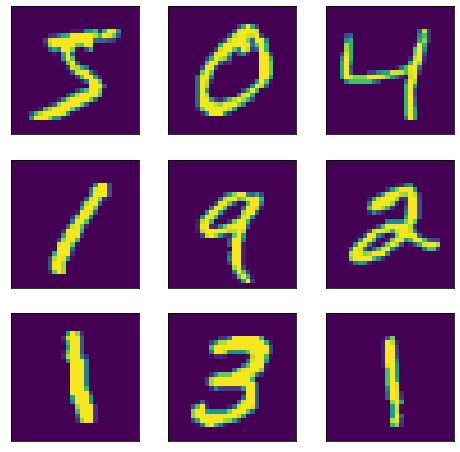

In [4]:
visualize(x['train'])

### Evaluate linear classifier

In [5]:
classifier = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1)
]
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.fit(x['train'], y['train'], validation_data=(x['test'], y['test']), epochs=999, batch_size=64, callbacks=callbacks)

Epoch 1/999
938/938 [==============================] - 6s 4ms/step - loss: 8.0353 - accuracy: 0.8144 - val_loss: 0.5631 - val_accuracy: 0.8903
Epoch 2/999
938/938 [==============================] - 4s 4ms/step - loss: 0.4155 - accuracy: 0.9110 - val_loss: 0.4042 - val_accuracy: 0.9178
Epoch 3/999
938/938 [==============================] - 4s 4ms/step - loss: 0.2792 - accuracy: 0.9297 - val_loss: 0.3183 - val_accuracy: 0.9328
Epoch 4/999
938/938 [==============================] - 4s 4ms/step - loss: 0.2186 - accuracy: 0.9425 - val_loss: 0.2776 - val_accuracy: 0.9354
Epoch 5/999
938/938 [==============================] - 4s 4ms/step - loss: 0.2085 - accuracy: 0.9454 - val_loss: 0.2885 - val_accuracy: 0.9459
Epoch 00005: early stopping


# Contrastive model

In [46]:
batch_size = 256
temperature = .1

In [47]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255.),
    tf.keras.layers.experimental.preprocessing.RandomRotation(.1)
])

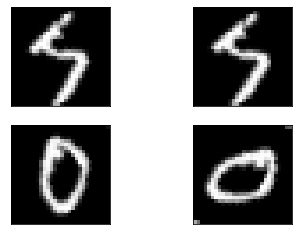

In [48]:
x_aug = {}
batch_size = 256
for type in ['train', 'test']:
    x_aug[type] = []
    for i in range(0, x[type].shape[0] - batch_size + 1, batch_size):
        x_batch = x[type][i:i+batch_size]
        x_batch = tf.repeat(x_batch[:, :, :, tf.newaxis], 3, axis=-1)
        x_batch_a = data_augmentation(x_batch)
        x_batch_b = data_augmentation(x_batch)
        x_batch_aug = tf.concat([x_batch_a, x_batch_b], axis=0)
        x_aug[type].append(x_batch_aug)
    x_aug[type] = tf.convert_to_tensor(x_aug[type], dtype=tf.float32)
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(x_aug['train'][0, 0])
ax[0, 1].imshow(x_aug['train'][0, batch_size])
ax[1, 0].imshow(x_aug['train'][0, 1])
ax[1, 1].imshow(x_aug['train'][0, batch_size + 1])
for i in range(4):
    ax[i // 2, i % 2].set_xticks([])
    ax[i // 2, i % 2].set_yticks([])
plt.show()

In [59]:
class ContrastiveModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        '''self.encoder = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(.5),
            tf.keras.layers.Dense(128, activation='relu')
        ])'''
        self.encoder = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu')
        ])
        self.training_head = tf.keras.layers.Dense(128)
        
    def call(self, x):
        x = self.encoder(x)
        x = self.training_head(x)
        z_i, z_j = tf.split(x, 2, axis=0)
        return z_i, z_j

In [60]:
def contrastive_loss(z_i, z_j, temperature=1.0):
    batch_size = tf.shape(z_i)[0]
    labels = tf.one_hot(tf.range(batch_size), batch_size * 2)
    mask = tf.one_hot(tf.range(batch_size), batch_size)
    logits_aa = tf.matmul(z_i, z_i, transpose_b=True) / temperature
    logits_aa -= mask * 1e9
    logits_bb = tf.matmul(z_j, z_j, transpose_b=True) / temperature
    logits_bb -= mask * 1e9
    logits_ab = tf.matmul(z_i, z_j, transpose_b=True) / temperature
    logits_ba = tf.matmul(z_j, z_i, transpose_b=True) / temperature
    loss_a = tf.nn.softmax_cross_entropy_with_logits(labels, tf.concat([logits_ab, logits_aa], 1))
    loss_b = tf.nn.softmax_cross_entropy_with_logits(labels, tf.concat([logits_ba, logits_bb], 1))
    loss = tf.reduce_mean(loss_a + loss_b)
    return loss, logits_ab, labels

In [61]:
optimizer = tf.keras.optimizers.Adam()
temperature = .1
model = ContrastiveModel()
best_test_loss = float('inf')
k = 0
for epoch in range(999):
    train_loss_avg = tf.keras.metrics.Mean()
    test_loss_avg = tf.keras.metrics.Mean()
    for batch in x_aug['train']:
        with tf.GradientTape() as tape:
            z_i, z_j = model(batch)
            loss, _, _ = contrastive_loss(z_i, z_j, temperature=temperature)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            train_loss_avg.update_state(loss)
    for batch in x_aug['test']:
        z_i, z_j = model(batch)
        loss, _, _ = contrastive_loss(z_i, z_j, temperature=temperature)
        test_loss_avg.update_state(loss)
    train_loss = train_loss_avg.result()
    test_loss = test_loss_avg.result()
    print(f'Train loss: {train_loss} Test loss: {test_loss}')
    if test_loss < best_test_loss:
        k = 0
        best_test_loss = test_loss
        print('Improved')
        model.save_weights('contrastive_weights.h5')
    else:
        k += 1
        if k >= 5:
            break

Train loss: 4.514532566070557 Test loss: 1.60652494430542
Improved
Train loss: 0.94931960105896 Test loss: 0.6916796565055847
Improved
Train loss: 0.4088791310787201 Test loss: 0.38086003065109253
Improved
Train loss: 0.23442889750003815 Test loss: 0.26989519596099854
Improved
Train loss: 0.16988380253314972 Test loss: 0.22995053231716156
Improved
Train loss: 0.14121492207050323 Test loss: 0.2319725751876831
Train loss: 0.13060423731803894 Test loss: 0.20734676718711853
Improved
Train loss: 0.1314667910337448 Test loss: 0.23689042031764984
Train loss: 0.12216880172491074 Test loss: 0.20314200222492218
Improved
Train loss: 0.14969658851623535 Test loss: 0.21390677988529205
Train loss: 0.12866586446762085 Test loss: 0.21022586524486542
Train loss: 0.11874403059482574 Test loss: 0.24092476069927216
Train loss: 0.12700170278549194 Test loss: 0.19103263318538666
Improved
Train loss: 0.10388112813234329 Test loss: 0.14357230067253113
Improved
Train loss: 0.12949901819229126 Test loss: 0.1874

In [62]:
model.load_weights('contrastive_weights.h5')
test_loss_avg = tf.keras.metrics.Mean()
for batch in x_aug['test']:
    z_i, z_j = model(batch)
    loss, _, _ = contrastive_loss(z_i, z_j, temperature=temperature)
    test_loss_avg.update_state(loss)
print('Test loss: ' + str(test_loss_avg.result().numpy()))

Test loss: 0.11399498


### Train supervised head

In [63]:
class ContrastiveProbe(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.trainable = False
        self.supervised_head = tf.keras.models.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        
    def call(self, x):
        x = self.model.encoder(x)
        return self.supervised_head(x)

In [64]:
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255.)
])

x_probe = {}
for type in ['train', 'test']:
    x_probe[type] = tf.repeat(x[type][:, :, :, tf.newaxis], 3, axis=-1)
    x_probe[type] = resize(x_probe[type])

In [65]:
supervised = ContrastiveProbe(model)
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
    tf.keras.callbacks.ModelCheckpoint('contrastive_probe.h5', save_best_only=True)
]
supervised.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
supervised.fit(x_probe['train'], y['train'], validation_data=(x_probe['test'], y['test']), batch_size=batch_size, epochs=999, callbacks=callbacks)

Epoch 1/999
235/235 [==============================] - 2s 5ms/step - loss: 1.4192 - accuracy: 0.5480 - val_loss: 0.7362 - val_accuracy: 0.7647
Epoch 2/999
235/235 [==============================] - 1s 5ms/step - loss: 0.7086 - accuracy: 0.7748 - val_loss: 0.6339 - val_accuracy: 0.7957
Epoch 3/999
235/235 [==============================] - 1s 5ms/step - loss: 0.6279 - accuracy: 0.7965 - val_loss: 0.5930 - val_accuracy: 0.8083
Epoch 4/999
235/235 [==============================] - 1s 5ms/step - loss: 0.5843 - accuracy: 0.8093 - val_loss: 0.5653 - val_accuracy: 0.8156
Epoch 5/999
235/235 [==============================] - 1s 5ms/step - loss: 0.5518 - accuracy: 0.8195 - val_loss: 0.5430 - val_accuracy: 0.8238
Epoch 6/999
235/235 [==============================] - 1s 6ms/step - loss: 0.5260 - accuracy: 0.8266 - val_loss: 0.5320 - val_accuracy: 0.8255
Epoch 7/999
235/235 [==============================] - 1s 6ms/step - loss: 0.5168 - accuracy: 0.8309 - val_loss: 0.5166 - val_accuracy: 0.8305

In [66]:
supervised.load_weights('contrastive_probe.h5')
loss, acc = supervised.evaluate(x_probe['test'], y['test'])
print(f'Accuracy: {acc:.3f}')

313/313 [==============================] - 1s 3ms/step - loss: 0.4001 - accuracy: 0.8701
Accuracy: 0.870


### Also try randomly initialized encoder

In [79]:
from tensorflow.keras.initializers import glorot_uniform
import tensorflow.keras.backend as K
rand_model = ContrastiveModel()
rand_model(x_probe['train'][0])
initial_weights = rand_model.get_weights()
new_weights = [glorot_uniform()(w.shape) for w in initial_weights]
rand_model.set_weights(new_weights)
rand_probe = ContrastiveProbe(model)
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
    tf.keras.callbacks.ModelCheckpoint('contrastive_probe_randomly_initialized.h5', save_best_only=True)
]
rand_probe.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rand_probe.fit(x_probe['train'], y['train'], validation_data=(x_probe['test'], y['test']), batch_size=batch_size, epochs=999, callbacks=callbacks)

Epoch 1/999
235/235 [==============================] - 2s 6ms/step - loss: 1.4620 - accuracy: 0.5356 - val_loss: 0.7432 - val_accuracy: 0.7658
Epoch 2/999
235/235 [==============================] - 1s 6ms/step - loss: 0.7252 - accuracy: 0.7692 - val_loss: 0.6371 - val_accuracy: 0.7980
Epoch 3/999
235/235 [==============================] - 1s 6ms/step - loss: 0.6363 - accuracy: 0.7936 - val_loss: 0.5962 - val_accuracy: 0.8064
Epoch 4/999
235/235 [==============================] - 1s 6ms/step - loss: 0.5845 - accuracy: 0.8107 - val_loss: 0.5704 - val_accuracy: 0.8149
Epoch 5/999
235/235 [==============================] - 1s 6ms/step - loss: 0.5632 - accuracy: 0.8162 - val_loss: 0.5488 - val_accuracy: 0.8204
Epoch 6/999
235/235 [==============================] - 1s 6ms/step - loss: 0.5341 - accuracy: 0.8231 - val_loss: 0.5396 - val_accuracy: 0.8240
Epoch 7/999
235/235 [==============================] - 1s 5ms/step - loss: 0.5203 - accuracy: 0.8279 - val_loss: 0.5219 - val_accuracy: 0.8285

In [80]:
rand_probe.load_weights('contrastive_probe_randomly_initialized.h5')
loss, acc = rand_probe.evaluate(x_probe['test'], y['test'])
print(f'Accuracy: {acc:.3f}')

313/313 [==============================] - 1s 3ms/step - loss: 0.3984 - accuracy: 0.8722
Accuracy: 0.872


### Also try unfrozen

In [81]:
unfrozen_model = ContrastiveModel()
unfrozen_probe = ContrastiveProbe(model)
unfrozen_probe.model.trainable = True
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
    tf.keras.callbacks.ModelCheckpoint('contrastive_probe_unfrozen.h5', save_best_only=True)
]
unfrozen_probe.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
unfrozen_probe.fit(x_probe['train'], y['train'], validation_data=(x_probe['test'], y['test']), batch_size=batch_size, epochs=999, callbacks=callbacks)

Epoch 1/999
235/235 [==============================] - 2s 6ms/step - loss: 0.7873 - accuracy: 0.7413 - val_loss: 0.1483 - val_accuracy: 0.9521
Epoch 2/999
235/235 [==============================] - 1s 6ms/step - loss: 0.1419 - accuracy: 0.9558 - val_loss: 0.1205 - val_accuracy: 0.9623
Epoch 3/999
235/235 [==============================] - 1s 5ms/step - loss: 0.0924 - accuracy: 0.9719 - val_loss: 0.1016 - val_accuracy: 0.9683
Epoch 4/999
235/235 [==============================] - 1s 6ms/step - loss: 0.0704 - accuracy: 0.9779 - val_loss: 0.1010 - val_accuracy: 0.9697
Epoch 5/999
235/235 [==============================] - 1s 6ms/step - loss: 0.0544 - accuracy: 0.9827 - val_loss: 0.0937 - val_accuracy: 0.9708
Epoch 6/999
235/235 [==============================] - 1s 6ms/step - loss: 0.0452 - accuracy: 0.9857 - val_loss: 0.0828 - val_accuracy: 0.9746
Epoch 7/999
235/235 [==============================] - 1s 6ms/step - loss: 0.0359 - accuracy: 0.9888 - val_loss: 0.0877 - val_accuracy: 0.9734

In [29]:
unfrozen_probe.load_weights('contrastive_probe_unfrozen.h5')
loss, acc = unfrozen_probe.evaluate(x_probe['test'], y['test'])
print(f'Accuracy: {acc:.3f}')

313/313 [==============================] - 1s 4ms/step - loss: 0.0202 - accuracy: 0.9932
Accuracy: 0.993
